# Scientific Initiation Project About Classifying Pinus Taeda Using Satelite Images
This work has as objective monitoring the spreading of Pinus Taeda on Ponta Grossa using Machine Learning algorithms applied on satelite images. In the next cells, I'll explain my code and thinking about the problem.

## 1. Libraries

In [62]:
import os
import random
import shutil
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from PIL import Image
import scipy

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

from tensorflow.keras.models import load_model

## 2. Importing Data

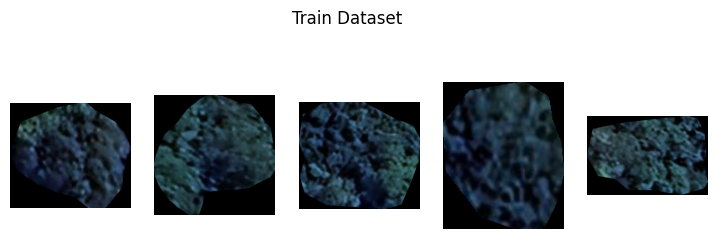

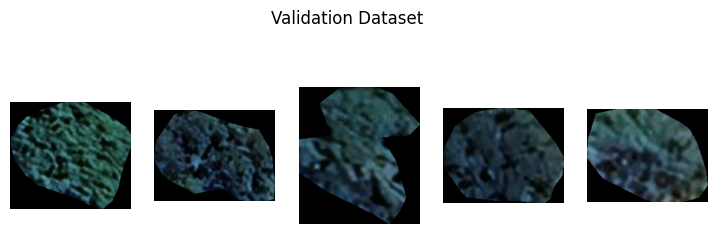

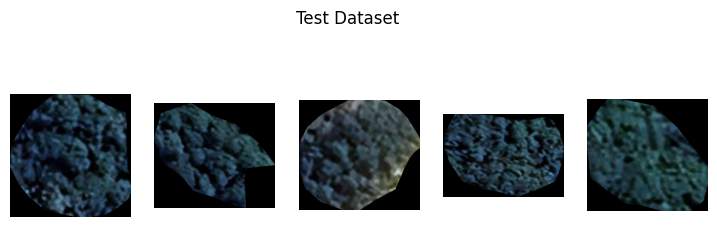

In [124]:
# Define paths
main_folder = '/home/shuruyi/Documents/qgis/google_satelite/extracted_images/'
train = '/home/shuruyi/Documents/qgis/google_satelite/train'
valid = '/home/shuruyi/Documents/qgis/google_satelite/validation'
test = '/home/shuruyi/Documents/qgis/google_satelite/test'

# Create train, validation, and test directories if they don't exist
os.makedirs(train, exist_ok=True)
os.makedirs(valid, exist_ok=True)
os.makedirs(test, exist_ok=True)

# List all TIFF files in the main folder
tif_files = [f for f in os.listdir(main_folder) if f.endswith('.tif')]

if not tif_files:
    # If main folder is empty, use the other folders
    train_files = [f for f in os.listdir(os.path.join(train, 'not-pinus')) if f.endswith('.tif')]
    train_files += [f for f in os.listdir(os.path.join(train, 'pinus')) if f.endswith('.tif')]
    valid_files = [f for f in os.listdir(os.path.join(valid, 'not-pinus')) if f.endswith('.tif')]
    valid_files += [f for f in os.listdir(os.path.join(valid, 'pinus')) if f.endswith('.tif')]
    test_files = [f for f in os.listdir(os.path.join(test, 'not-pinus')) if f.endswith('.tif')]
    test_files += [f for f in os.listdir(os.path.join(test, 'pinus')) if f.endswith('.tif')]
else:
    # Define the ratio for train-validation-test split (e.g., 70-20-10 split)
    train_ratio = 0.7
    valid_ratio = 0.2
    test_ratio = 1 - train_ratio - valid_ratio

    # Randomly shuffle the list of files
    random.shuffle(tif_files)

    # Split the data into train, validation, and test sets
    train_files, test_files = train_test_split(tif_files, test_size=test_ratio, random_state=42)
    train_files, valid_files = train_test_split(train_files, test_size=valid_ratio / (train_ratio + valid_ratio),
                                                random_state=42)

    # Move files to train, validation, and test folders
    for file in train_files:
        src = os.path.join(main_folder, file)
        # Extract label from the filename
        # label = int(file.split('_label_')[-1].split('.')[0])
        file_name = os.path.basename(file)
        if file_name.startswith('not-pinus'): 
            dst = os.path.join(train, 'not-pinus', file)
        else:
            dst = os.path.join(train, 'pinus', file)
        shutil.move(src, dst)

    for file in valid_files:
        src = os.path.join(main_folder, file)
        # Extract label from the filename
        # label = int(file.split('_label_')[-1].split('.')[0])
        file_name = os.path.basename(file)
        if file_name.startswith('not-pinus'): 
            dst = os.path.join(valid, 'not-pinus', file)
        else:
            dst = os.path.join(valid, 'pinus', file)
        shutil.move(src, dst)

    for file in test_files:
        src = os.path.join(main_folder, file)
        # Extract label from the filename
        # label = int(file.split('_label_')[-1].split('.')[0])
        file_name = os.path.basename(file)
        if file_name.startswith('not-pinus'): 
            dst = os.path.join(test, 'not-pinus', file)
        else:
            dst = os.path.join(test, 'pinus', file)
        shutil.move(src, dst)
        
# Convert lists to DataFrames
train_df = pd.DataFrame(train_files, columns=['file_name'])
valid_df = pd.DataFrame(valid_files, columns=['file_name'])
test_df = pd.DataFrame(test_files, columns=['file_name'])

# Function to plot images from a DataFrame
def plot_images(df, title, base_folder):
    fig, axes = plt.subplots(1, 5, figsize=(9, 3))
    fig.suptitle(title)
    for i, (_, row) in enumerate(df.head(5).iterrows()):
        file_name = row['file_name']
        subfolder = 'not-pinus' if file_name.startswith('not-pinus') else 'pinus'
        file_path = os.path.join(base_folder, subfolder, file_name)
        img = Image.open(file_path)
        axes[i].imshow(img)
        axes[i].axis('off')

# Plot images from train_df
plot_images(train_df, 'Train Dataset', train)

# Plot images from valid_df
plot_images(valid_df, 'Validation Dataset', valid)

# Plot images from test_df
plot_images(test_df, 'Test Dataset', test)

plt.show()


In [102]:
# Store the test_df on a pdf with the true labels

# Path to csv
csv_filepath = '/home/shuruyi/Documents/qgis/google_satelite/test_labels.csv'

# Extract labels from file names
# test_labels = [int(file.split('_label_')[-1].split('.')[0]) for file in test_files]
test_labels = []
for file in test_files:
    if file.startswith('not-pinus'): 
        test_labels.append(0)
    else:
        test_labels.append(1)

# Add the column label to the test_df
test_df['labels'] = test_labels

test_df

if not os.path.isfile(csv_filepath):
    # Define the file path where you want to save the CSV fil
    test_df.to_csv(csv_filepath, index=False)
    print("CSV saved sucessfully")
else:
    print("CSV already on the directory.")

CSV saved sucessfully


## 3. Preprocessing data

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

# Define model architecture (U-Net)
def unet(input_shape=(256, 256, 3)):
    inputs = Input(input_shape)
    
    # Encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    # Decoder
    up3 = UpSampling2D(size=(2, 2))(pool2)
    up3 = Conv2D(64, (2, 2), activation='relu', padding='same')(up3)
    merge3 = concatenate([conv2, up3], axis=3)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge3)
    up4 = UpSampling2D(size=(2, 2))(conv3)
    up4 = Conv2D(32, (2, 2), activation='relu', padding='same')(up4)
    merge4 = concatenate([conv1, up4], axis=3)
    conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(merge4)
    
    # Output
    outputs = Conv2D(3, (1, 1), activation='sigmoid')(conv4)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Define data generators
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Assuming 'train' and 'valid' are paths to the directories containing respective data
train_generator = train_datagen.flow_from_directory(
    train,
    target_size=(256, 256),
    batch_size=32,
    class_mode='input',  # Using input images as labels for unsupervised training
    color_mode='rgb',  # Ensure RGB color mode for input images
    shuffle=True
)

valid_generator = valid_datagen.flow_from_directory(
    valid,
    target_size=(256, 256),
    batch_size=32,
    class_mode='input',
    color_mode='rgb',  # Ensure RGB color mode for input images
    shuffle=False
)

# Build and train the U-Net model
model = unet(input_shape=(256, 256, 3))
model.summary()

# Define callbacks for model training
callbacks = [
    ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss", verbose=1)
]

# Train the model
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    callbacks=callbacks
)

Found 202 images belonging to 2 classes.
Found 59 images belonging to 2 classes.


Model: "functional_139"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_27      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_141 (Conv2D) │ (None, 256, 256,  │        896 │ input_layer_27[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_66    │ (None, 128, 128,  │          0 │ conv2d_141[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_142 (Conv2D) │ (None, 128, 128,  │     18,496 │ max_pooling2d_66… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_67    │ (None, 64, 64,    │          0 │ conv2d_142[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_30    │ (None, 128, 128,  │          0 │ max_pooling2d_67… │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_143 (Conv2D) │ (None, 128, 128,  │     16,448 │ up_sampling2d_30… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_30      │ (None, 128, 128,  │          0 │ conv2d_142[0][0], │
│ (Concatenate)       │ 128)              │            │ conv2d_143[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_144 (Conv2D) │ (None, 128, 128,  │     73,792 │ concatenate_30[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_31    │ (None, 256, 256,  │          0 │ conv2d_144[0][0]  │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_145 (Conv2D) │ (None, 256, 256,  │      8,224 │ up_sampling2d_31… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_31      │ (None, 256, 256,  │          0 │ conv2d_141[0][0], │
│ (Concatenate)       │ 64)               │            │ conv2d_145[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_146 (Conv2D) │ (None, 256, 256,  │     18,464 │ concatenate_31[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_147 (Conv2D) │ (None, 256, 256,  │         99 │ conv2d_146[0][0]  │
│                     │ 3)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 136,419 (532.89 KB)

 Trainable params: 136,419 (532.89 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


/home/shuruyi/Documents/git/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2973 - loss: 0.6664
Epoch 1: val_loss improved from inf to 0.51943, saving model to best_model.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 47s 6s/step - accuracy: 0.2980 - loss: 0.6623 - val_accuracy: 0.3064 - val_loss: 0.5194
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5664 - loss: 0.5115
Epoch 2: val_loss improved from 0.51943 to 0.42533, saving model to best_model.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 43s 7s/step - accuracy: 0.5748 - loss: 0.5092 - val_accuracy: 0.6353 - val_loss: 0.4253
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6518 - loss: 0.3986
Epoch 3: val_loss improved from 0.42533 to 0.29334, saving model to best_model.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 43s 6s/step - accuracy: 0.6519 - loss: 0.3953 - val_accuracy: 0.4816 - val_loss: 0.2933
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.4509 - loss: 0.2986
Epoch 4: val_loss improved from 0.29334 to 0.28576, saving model to best_model.keras
7/7 ━━━━━━━━

In [103]:
# CNN model parameters
img_width, img_height = 150, 150
input_shape = (img_width, img_height, 3)
batch_size = 32

# Data preprocessing and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Assuming 'train' and 'valid' are paths to the directories containing respective data
train_generator = train_datagen.flow_from_directory(
    train,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

valid_generator = valid_datagen.flow_from_directory(
    valid,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

test_generator = valid_datagen.flow_from_directory(
    test,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

# Flatten the image data
def flatten_images(generator):
    num_samples = generator.samples
    x_data = np.zeros((num_samples, img_width * img_height * 3))
    y_data = np.zeros((num_samples,))
    for i, (x_batch, y_batch) in enumerate(generator):
        x_batch_flat = x_batch.reshape(x_batch.shape[0], -1)
        x_data[i * batch_size : i * batch_size + x_batch.shape[0]] = x_batch_flat
        y_data[i * batch_size : i * batch_size + y_batch.shape[0]] = y_batch
        if i >= num_samples // batch_size:
            break
    return x_data, y_data

Found 202 images belonging to 2 classes.
Found 59 images belonging to 2 classes.


Found 30 images belonging to 2 classes.


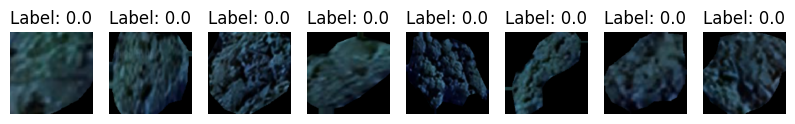

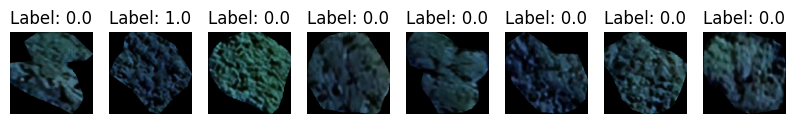

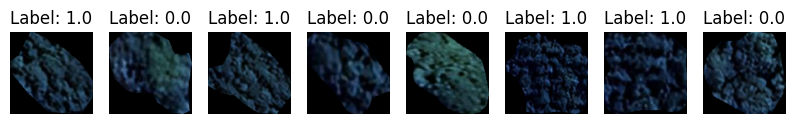

In [126]:
# Define a function to plot random images
def plot_random_images(generator, num_images=8):
    # Get a batch of images and labels from the generator
    x_batch, y_batch = next(generator)
    
    # Get random indices to select random images
    random_indices = np.random.choice(range(len(x_batch)), num_images, replace=False)
    
    # Plot the random images
    plt.figure(figsize=(10, 10))
    for i, idx in enumerate(random_indices):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(x_batch[idx])
        plt.title(f"Label: {y_batch[idx]}")
        plt.axis('off')
    plt.show()

# Plot random images from the train generator
plot_random_images(train_generator, num_images=8)

# Plot random images from the valid generator
plot_random_images(valid_generator, num_images=8)

# Plot random images from the test generator
plot_random_images(test_generator, num_images=8)

## 4. Trainning the model

### CNN Model

In [112]:
# Define seed for reproducibility
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# Define CNN model parameters
img_width, img_height = 150, 150
input_shape = (img_width, img_height, 3)
batch_size = 32
epochs = 14

# Define CNN model architecture
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks for model training
callbacks = [
    ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss"),
    EarlyStopping(monitor="val_loss", patience=3)
]

# Train the model
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=epochs,
    callbacks=callbacks
)

# Print training and validation loss and accuracy
print("Training Loss:", history.history['loss'])
print("Training Accuracy:", history.history['accuracy'])
print("Validation Loss:", history.history['val_loss'])
print("Validation Accuracy:", history.history['val_accuracy'])

Epoch 1/14
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 373ms/step - accuracy: 0.5369 - loss: 0.9424 - val_accuracy: 0.5932 - val_loss: 0.6927
Epoch 2/14
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 343ms/step - accuracy: 0.6027 - loss: 0.6924 - val_accuracy: 0.5932 - val_loss: 0.6929
Epoch 3/14
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 353ms/step - accuracy: 0.5959 - loss: 0.6929 - val_accuracy: 0.5932 - val_loss: 0.6929
Epoch 4/14
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 345ms/step - accuracy: 0.5872 - loss: 0.6929 - val_accuracy: 0.5932 - val_loss: 0.6929
Training Loss: [0.8655319809913635, 0.6934808492660522, 0.6935479044914246, 0.6933581829071045]
Training Accuracy: [0.39603960514068604, 0.4455445408821106, 0.4455445408821106, 0.4455445408821106]
Validation Loss: [0.6927294135093689, 0.692875862121582, 0.6929231286048889, 0.6928952932357788]
Validation Accuracy: [0.5932203531265259, 0.5932203531265259, 0.5932203531265259, 0.5932203531265259]


### RandomForest Model

In [113]:
# Get the flattened image data
x_train, y_train = flatten_images(train_generator)
x_valid, y_valid = flatten_images(valid_generator)
x_test, y_test = flatten_images(test_generator)

# Train RandomForest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

### SVM Model

In [118]:
# Get the flattened image data
x_train, y_train = flatten_images(train_generator)
x_valid, y_valid = flatten_images(valid_generator)
x_test, y_test = flatten_images(test_generator)

# Train SVM Classifier
svm_classifier = SVC(kernel='linear', random_state=42)
svm_classifier.fit(x_train, y_train)

SVC(kernel='linear', random_state=42)

## 5. Loading a Save Model

In [20]:
# Load the model
model = load_model('./IC/satelite/best_model.h5')

In [21]:
# Verify the model
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

## 6. Making Predictions

### CNN Predictions

In [114]:
# Get list of all .tif files in the 'pinus' and 'not-pinus' subfolders
test_image_files = [os.path.join(test, folder, f) 
                    for folder in ['pinus', 'not-pinus'] 
                    for f in os.listdir(os.path.join(test, folder)) 
                    if f.endswith('.tif')]

# Prepare data for testing
test_images = []
for image_path in test_image_files:
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(img_width, img_height))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img / 255.0  # Normalize pixel values
    test_images.append(img)

# Convert the list of images to numpy array
test_images = np.array(test_images)

# Get predictions for the test data
predictions = model.predict(test_images)

# Convert probabilities to binary predictions (0 or 1) using a threshold (e.g., 0.5)
binary_predictions = (predictions > 0.5).astype(int)

# Create a DataFrame for binary predictions
binary_predictions_df = pd.DataFrame(binary_predictions, columns=['binary_predictions'])
binary_predictions_df

# Concatenate test_df file names with binary_predictions
cnn_pred_df = pd.concat([test_df.file_name, binary_predictions_df], axis=1)

# Print the pred_df
cnn_pred_df

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


,file_name,binary_predictions
0,not-pinus_105.tif,1
1,not-pinus_58.tif,1
2,not-pinus_83.tif,1
3,not-pinus_2.tif,1
4,not-pinus_15.tif,1
5,not-pinus_120.tif,1
6,not-pinus_146.tif,1
7,not-pinus_4.tif,1
8,not-pinus_63.tif,1
9,not-pinus_37.tif,1


### Random Forest Predictions

In [115]:
# Predict and evaluate
y_train_pred = rf_classifier.predict(x_train)
y_valid_pred = rf_classifier.predict(x_valid)
y_test_pred= rf_classifier.predict(x_test)

# Create a DataFrame for binary predictions
binary_predictions_df = pd.DataFrame(y_test_pred, columns=['binary_predictions'])
binary_predictions_df

# Concatenate test_df file names with binary_predictions
rf_pred_df = pd.concat([test_df.file_name, binary_predictions_df], axis=1)

# Print y_pred_df
rf_pred_df

,file_name,binary_predictions
0,not-pinus_105.tif,0.0
1,not-pinus_58.tif,1.0
2,not-pinus_83.tif,0.0
3,not-pinus_2.tif,0.0
4,not-pinus_15.tif,0.0
5,not-pinus_120.tif,0.0
6,not-pinus_146.tif,1.0
7,not-pinus_4.tif,0.0
8,not-pinus_63.tif,1.0
9,not-pinus_37.tif,0.0


### SVM Predictions

In [120]:
# Predict and evaluate
y_train_pred = svm_classifier.predict(x_train)
y_valid_pred = svm_classifier.predict(x_valid)
y_test_pred= svm_classifier.predict(x_test)

# Create a DataFrame for binary predictions
binary_predictions_df = pd.DataFrame(y_test_pred, columns=['binary_predictions'])
binary_predictions_df

# Concatenate test_df file names with binary_predictions
svm_pred_df = pd.concat([test_df.file_name, binary_predictions_df], axis=1)

# Print y_pred_df
svm_pred_df

,file_name,binary_predictions
0,not-pinus_105.tif,0.0
1,not-pinus_58.tif,0.0
2,not-pinus_83.tif,0.0
3,not-pinus_2.tif,1.0
4,not-pinus_15.tif,0.0
5,not-pinus_120.tif,0.0
6,not-pinus_146.tif,1.0
7,not-pinus_4.tif,0.0
8,not-pinus_63.tif,1.0
9,not-pinus_37.tif,0.0


## 7. Results

### CNN Results

In [116]:
# Assuming true labels are stored in a variable called true_labels
true_labels = test_df['labels'].values  # Extracting true labels from the DataFrame

# Assuming predicted binary values are in the concatenated_df DataFrame under 'Binary_Predictions' column
predicted_values = cnn_pred_df['binary_predictions'].values  # Extracting predicted binary values

# Calculate accuracy using accuracy_score
accuracy = accuracy_score(true_labels, predicted_values)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Calculate precision using precision_score
precision = precision_score(true_labels, predicted_values)
print(f"Precision: {precision}")

# Calculate recall using recall_score
recall = recall_score(true_labels, predicted_values)
print(f"Recall: {recall}")

# Calculate f1-score using f1_score
f1_score_value = f1_score(true_labels, predicted_values)
print(f"F1-Score: {f1_score_value}")

Accuracy: 53.33%
Precision: 0.5333333333333333
Recall: 1.0
F1-Score: 0.6956521739130435


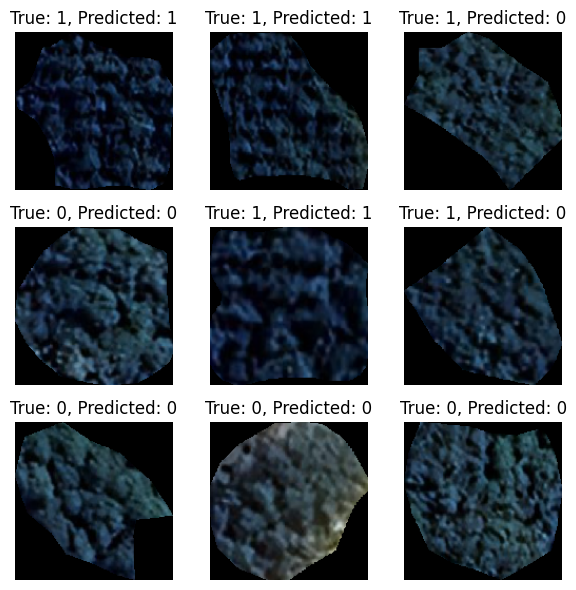

In [76]:
# Assuming 'test_image_files' contains the file paths of test images
# Assuming 'binary_predictions' contains the binary predictions for the test images

# Define a function to plot images with labels
def plot_images(images, true_labels, predicted_labels):
    plt.figure(figsize=(6, 6))
    for i in range(len(images)):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"True: {true_labels[i]}, Predicted: {predicted_labels[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Load and plot a sample of test images with true and predicted labels
sample_size = min(9, len(test_images))  # Adjust the sample size if needed
sample_images = test_images[:sample_size]
sample_true_labels = true_labels[:sample_size]  # Assuming true_labels is defined
sample_predicted_labels = binary_predictions.flatten()[:sample_size]

plot_images(sample_images, sample_true_labels, sample_predicted_labels)

Length of true_labels: 30
Length of binary_predictions: 30
Incorrect indices: [2, 5, 11, 13, 16, 17, 20, 23, 26]


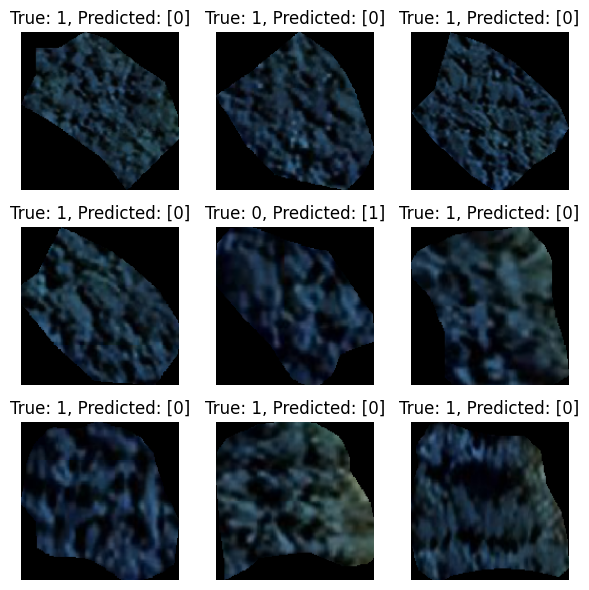

In [77]:
# Assuming 'test_image_files' contains the file paths of test images
# Assuming 'true_labels' contains the true labels for the test images
# Assuming 'binary_predictions' contains the binary predictions for the test images

# Print the lengths of the lists for debugging
print("Length of true_labels:", len(true_labels))
print("Length of binary_predictions:", len(binary_predictions))

# Identify indices of images with incorrect predictions
incorrect_indices = [i for i in range(len(true_labels)) if true_labels[i] != binary_predictions[i]]
print("Incorrect indices:", incorrect_indices)  # Print the incorrect indices for debugging

# Define a function to plot images with labels
def plot_incorrect_images(images, true_labels, predicted_labels):
    plt.figure(figsize=(6, 6))
    for i in range(len(images)):
        plt.subplot(3, 3, i % 9 + 1)  # Adjusted subplot indices to fit within 1-9
        plt.imshow(images[i])
        plt.title(f"True: {true_labels[i]}, Predicted: {predicted_labels[i]}")
        plt.axis('off')
        if (i + 1) % 9 == 0 or i == len(images) - 1:  # Break after plotting 9 images or at the end of the list
            plt.tight_layout()
            plt.show()
            if i != len(images) - 1:  # Start a new figure if there are more images to plot
                plt.figure(figsize=(6, 6))

# Get images with incorrect predictions
incorrect_images = [test_images[idx] for idx in incorrect_indices]
incorrect_true_labels = [true_labels[idx] for idx in incorrect_indices]
incorrect_predicted_labels = [binary_predictions[idx] for idx in incorrect_indices]

# Plot images with incorrect predictions
plot_incorrect_images(incorrect_images, incorrect_true_labels, incorrect_predicted_labels)

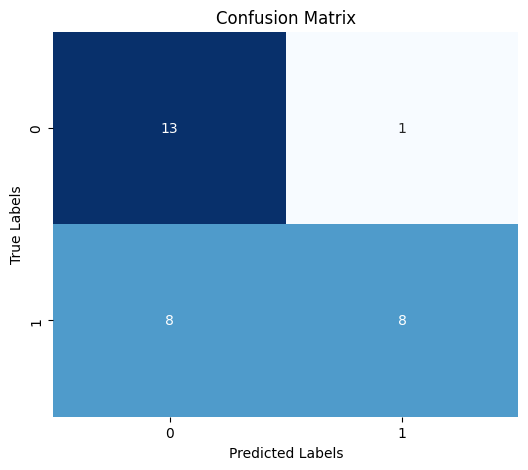

In [78]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_values)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### Random Forest results

In [117]:
# Assuming true labels are stored in a variable called true_labels
true_labels = test_df['labels'].values  # Extracting true labels from the DataFrame

# Assuming predicted binary values are in the concatenated_df DataFrame under 'Binary_Predictions' column
predicted_values = rf_pred_df['binary_predictions'].values  # Extracting predicted binary values

# Calculate accuracy using accuracy_score
accuracy = accuracy_score(true_labels, predicted_values)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Calculate precision using precision_score
precision = precision_score(true_labels, predicted_values)
print(f"Precision: {precision}")

# Calculate recall using recall_score
recall = recall_score(true_labels, predicted_values)
print(f"Recall: {recall}")

# Calculate f1-score using f1_score
f1_score_value = f1_score(true_labels, predicted_values)
print(f"F1-Score: {f1_score_value}")

Accuracy: 80.00%
Precision: 0.8125
Recall: 0.8125
F1-Score: 0.8125


### SVM Results

In [121]:
# Assuming true labels are stored in a variable called true_labels
true_labels = test_df['labels'].values  # Extracting true labels from the DataFrame

# Assuming predicted binary values are in the concatenated_df DataFrame under 'Binary_Predictions' column
predicted_values = svm_pred_df['binary_predictions'].values  # Extracting predicted binary values

# Calculate accuracy using accuracy_score
accuracy = accuracy_score(true_labels, predicted_values)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Calculate precision using precision_score
precision = precision_score(true_labels, predicted_values)
print(f"Precision: {precision}")

# Calculate recall using recall_score
recall = recall_score(true_labels, predicted_values)
print(f"Recall: {recall}")

# Calculate f1-score using f1_score
f1_score_value = f1_score(true_labels, predicted_values)
print(f"F1-Score: {f1_score_value}")

Accuracy: 76.67%
Precision: 0.8
Recall: 0.75
F1-Score: 0.7741935483870968


# Testing something

In [161]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

# Define model architecture (U-Net)
def unet(input_shape=(256, 256, 3)):
    inputs = Input(input_shape)
    
    # Encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    # Decoder
    up3 = UpSampling2D(size=(2, 2))(pool2)
    up3 = Conv2D(64, (2, 2), activation='relu', padding='same')(up3)
    merge3 = concatenate([conv2, up3], axis=3)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge3)
    up4 = UpSampling2D(size=(2, 2))(conv3)
    up4 = Conv2D(32, (2, 2), activation='relu', padding='same')(up4)
    merge4 = concatenate([conv1, up4], axis=3)
    conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(merge4)
    
    # Output
    outputs = Conv2D(3, (1, 1), activation='sigmoid')(conv4)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Define data generators
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Assuming 'train' and 'valid' are paths to the directories containing respective data
train_generator = train_datagen.flow_from_directory(
    train,
    target_size=(256, 256),
    batch_size=32,
    class_mode='input',  # Using input images as labels for unsupervised training
    color_mode='rgb',  # Ensure RGB color mode for input images
    shuffle=True
)

valid_generator = valid_datagen.flow_from_directory(
    valid,
    target_size=(256, 256),
    batch_size=32,
    class_mode='input',
    color_mode='rgb',  # Ensure RGB color mode for input images
    shuffle=False
)

# Build and train the U-Net model
model = unet(input_shape=(256, 256, 3))
model.summary()

# Define callbacks for model training
callbacks = [
    ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss", verbose=1)
]

# Train the model
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    callbacks=callbacks
)

Found 202 images belonging to 2 classes.
Found 59 images belonging to 2 classes.


Model: "functional_139"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_27      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_141 (Conv2D) │ (None, 256, 256,  │        896 │ input_layer_27[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_66    │ (None, 128, 128,  │          0 │ conv2d_141[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_142 (Conv2D) │ (None, 128, 128,  │     18,496 │ max_pooling2d_66… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_67    │ (None, 64, 64,    │          0 │ conv2d_142[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_30    │ (None, 128, 128,  │          0 │ max_pooling2d_67… │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_143 (Conv2D) │ (None, 128, 128,  │     16,448 │ up_sampling2d_30… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_30      │ (None, 128, 128,  │          0 │ conv2d_142[0][0], │
│ (Concatenate)       │ 128)              │            │ conv2d_143[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_144 (Conv2D) │ (None, 128, 128,  │     73,792 │ concatenate_30[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_31    │ (None, 256, 256,  │          0 │ conv2d_144[0][0]  │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_145 (Conv2D) │ (None, 256, 256,  │      8,224 │ up_sampling2d_31… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_31      │ (None, 256, 256,  │          0 │ conv2d_141[0][0], │
│ (Concatenate)       │ 64)               │            │ conv2d_145[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_146 (Conv2D) │ (None, 256, 256,  │     18,464 │ concatenate_31[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_147 (Conv2D) │ (None, 256, 256,  │         99 │ conv2d_146[0][0]  │
│                     │ 3)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 136,419 (532.89 KB)

 Trainable params: 136,419 (532.89 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


/home/shuruyi/Documents/git/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2973 - loss: 0.6664
Epoch 1: val_loss improved from inf to 0.51943, saving model to best_model.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 47s 6s/step - accuracy: 0.2980 - loss: 0.6623 - val_accuracy: 0.3064 - val_loss: 0.5194
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5664 - loss: 0.5115
Epoch 2: val_loss improved from 0.51943 to 0.42533, saving model to best_model.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 43s 7s/step - accuracy: 0.5748 - loss: 0.5092 - val_accuracy: 0.6353 - val_loss: 0.4253
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6518 - loss: 0.3986
Epoch 3: val_loss improved from 0.42533 to 0.29334, saving model to best_model.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 43s 6s/step - accuracy: 0.6519 - loss: 0.3953 - val_accuracy: 0.4816 - val_loss: 0.2933
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.4509 - loss: 0.2986
Epoch 4: val_loss improved from 0.29334 to 0.28576, saving model to best_model.keras
7/7 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


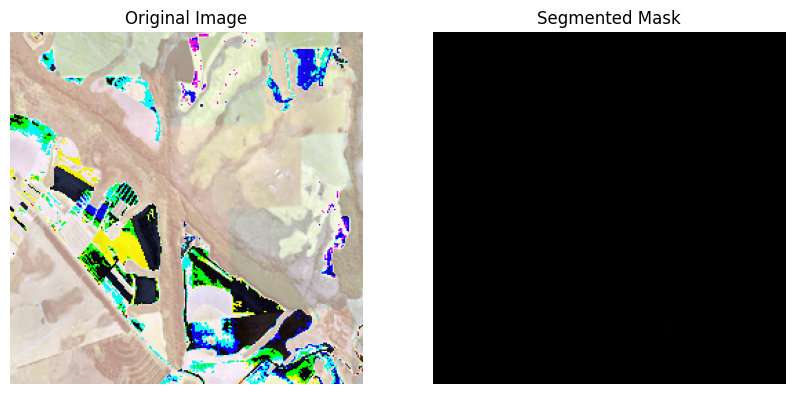

In [175]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
import tifffile as tiff

def load_and_preprocess_image(image_path, target_size=(256, 256)):
    # Load the TIFF image using tifffile
    img = tiff.imread(image_path)
    # Ensure the image has the correct number of channels (e.g., for RGB images)
    if img.shape[-1] != 3:
        img = img[..., :3]  # Keep only the first 3 channels if more than 3
    # Resize the image to the target size
    img_resized = image.array_to_img(img)
    img_resized = img_resized.resize(target_size)
    # Convert the resized image to a numpy array
    img_array = image.img_to_array(img_resized)
    # Preprocess the image (e.g., normalize pixel values)
    img_preprocessed = preprocess_input(img_array)
    # Return the preprocessed image
    return img_preprocessed

# Load and preprocess the test image (assuming 'test_image_path' is the path to your test image)
test_image = load_and_preprocess_image('/home/shuruyi/Documents/qgis/google_satelite/testing_something/google_satelite.tif')

# Perform inference on the test image
segmented_mask = model.predict(np.expand_dims(test_image, axis=0))[0]

# Post-processing: Visualize the segmented mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(test_image.astype(np.uint8))  # Convert back to uint8 for display
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(segmented_mask.squeeze(), cmap='gray')
plt.title('Segmented Mask')
plt.axis('off')

plt.show()